In [14]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [2]:
# FFT code (adapted from Nederhof)
# compares the FFT results for two images
def dist(fft_real1, fft_imag1, fft_real2, fft_imag2):
    d = 0
    for x in range(size):
        for y in range(size):
            d += abs(fft_real1[x][y] - fft_real2[x][y]) * weight2(x,y)
            d += abs(fft_imag1[x][y] - fft_imag2[x][y]) * weight2(x,y)
    return d

def weight2(x,y):
    if x >= C or y >= C:
        return 0
    if y == 0 and x == 10:
        return g 
    if y == 0 and x == 11:
        return g 
    if y == 0 and x == 12:
        return g 
    if y == 0 and x == 5:
        return g 
    else:
        return D + (C-x) + (C-y)

In [3]:
# IDM code (adapted from Nederhof)

# assume pixels outside of the image are white
def get_safe(im, x, y):
     if x < 0 or x >= size or y < 0 or y >= size:
        return 255
     else:
        return im[x][y]
    
# compares a window of size "context" around a pixel in an 
# image with another window of the same size in another image. Returned is
# the number of pixels where the two windows are distinct.
def distort_window(im1, im2, x1, y1, x2, y2):
    cost = 0
    for xd in range(-context, context+1):
        for yd in range(-context, context+1):
            if get_safe(im1, x1+xd, y1+yd) != get_safe(im2, x2+xd, y2+yd):
                cost += 1
    return cost

# compares windows as above, but warped up to a certain
# distance "warp", taking the optimal cost from all possibilities
def distort(im1, im2, x1, y1):
    best_cost = (1 + 2 * context) * (1 + 2 * context)
    for x2 in range(x1-warp, x1+warp+1):
        for y2 in range(y1-warp, y1+warp+1):
            cost = distort_window(im1, im2, x1, y1, x2, y2)
            if cost < best_cost:
                best_cost = cost
    return best_cost

# compare two images using IDM
def distance(im1, im2):
    diff = 0
    for x1 in range(size):
        for y1 in range(size):
            diff += distort(im1, im2, x1, y1)
    return diff

In [10]:
# actually do the comparison
def IDM(location, bounds, size, C, D, g, fft_thresh, context, warp):
    
    # load new image(s)
    new = Image.open(location)
    width, height = new.size
    new_ratio = height / width
    
    # load in aspect ratio list and pixel values for the data set
    datalist = pd.read_csv('/Users/.../datasetstats.csv', index_col=[0])
    pxls = pd.read_csv('/Users/.../pxls_20.csv', index_col=[0])
    
    # filter by aspect ratio
    rows, cols = datalist.shape
    
    saved = [] 
    for i in range(rows):
            if datalist.iat[i,2] < new_ratio + bounds and datalist.iat[i,2] > new_ratio - bounds:
                name = datalist.iat[i,0]
                position = name.index('.') # gets position of the _0 in the filename
                value = name[0:position]
                saved.append(value)

    print('There are ' + str(len(saved)) + ' images not filtered out by aspect ratio.') # see how many images are left after filtering
    saved_pxls = pxls.loc[pxls['0'].isin(saved)] # pixel values for saved images    

    # make the new image the same size as the dataset images and save its pixel values
    new_resize = new.resize((size,size))
    new_pxls = np.zeros(size*size)
    d = 0

    for i in range(size):
        for k in range(size):
            l,m,n,o = new_resize.getpixel((k, i))
            if l > 127.5:
                 new_pxls[d] = 255
            if l < 127.5:
                new_pxls[d] = 0
            d += 1

    # make the pixels vector a matrix and calculate the new images' FFTs
    saved_pxls = saved_pxls.reset_index(drop=True) # fix axes for saved pixels dataframe
    saved_pxls = saved_pxls.T.reset_index(drop=True).T
    new_pxls = np.split(new_pxls, size)
    new_fft = np.fft.fft(new_pxls)
        
    # compare new image's FFT to saved images' FFTs
    new_rows = len(saved_pxls)
    FFT_scores = np.zeros(new_rows)
    for i in range(new_rows):
        temp = saved_pxls.loc[i].to_numpy()
        temp = temp[1:]
        temp = np.split(temp, size)
        fft_temp = np.fft.fft(temp)
        FFT_scores[i] = dist(new_fft.real, new_fft.imag, fft_temp.real, fft_temp.imag)
            
    # sort FFT scores
    FFT_simil = saved_pxls[0]
    FFT_simil = pd.DataFrame(FFT_simil)
    FFT_scores_df = pd.DataFrame(FFT_scores)
    FFT_simil['FFT Score'] = FFT_scores_df

    FFT_simil = FFT_simil.sort_values(by=['FFT Score'], ascending=True) # sort by smallest FFT score first

    # filter out images with FFT_scores larger than the threshold
    saved = [] 
    for i in range(len(FFT_simil)):
            if FFT_simil.iat[i,1] < fft_thresh:
                value = FFT_simil.iat[i,0]
                saved.append(value)

    print('There are ' + str(len(saved)) + ' images not filtered out by FFT.') # see how many images are left after filtering
    saved_pxls_FFT = saved_pxls.loc[saved_pxls.loc[:,0].isin(saved)] # pixel values for saved images
        
    # compare the new image to the dataset
    saved_pxls_FFT = saved_pxls_FFT.reset_index(drop=True) # fix axes for saved pixels dataframe
    saved_pxls_FFT = saved_pxls_FFT.T.reset_index(drop=True).T
    new_rows = len(saved_pxls_FFT)
    scores = np.zeros(new_rows)
    saved_pxls = saved_pxls_FFT

    for j in range(new_rows):
        temp = saved_pxls.loc[j].to_numpy()
        temp = temp[1:]
        temp = np.split(temp, size)
        scores[j] = distance(new_pxls, temp)
   
    # add similarity scores and sort, then save to result tables
    
    full_results = pd.DataFrame() #initalize result dataframes
    results = pd.DataFrame()

    simil = saved_pxls_FFT[0]
    simil = pd.DataFrame(simil)
    scores_df = pd.DataFrame(scores)
    simil['Similarity Score'] = scores_df

    simil = simil.sort_values(by=['Similarity Score'], ascending=True) # sort by smallest difference score first

    simil = simil.reset_index(drop=True) # fix axes for similarity scores dataframe
    simil = simil.T.reset_index(drop=True).T
    simil = simil.rename(columns={0:'Sign', 1:'Similarity Score'}) 

    resulter = simil

    full_results = pd.concat([full_results, resulter], axis=1)
    results = pd.concat([results, resulter.iloc[:,0]], axis=1)
        
    # print the top 10 results and save all the results
    top_10 = simil.head(10)
    place = '/Users/.../Dataset Whole/' # the whole data set ("Dataset Whole"); remember the / after the folder name!
    fig = plt.figure(figsize=(20, 7))  

    for i in range(len(top_10)):
        image = Image.open(place + top_10.iat[i,0] + '.png')
        fig.add_subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
        plt.title('Number ' + str(i+1)  + '\n' + top_10.iat[i,0] + '\nSimilarity Score = '  + str(top_10.iat[i,1]))
  
    return full_results, results


In [11]:
# fft comparison
def FFT_only(location, bounds, size, C, D, g, fft_thresh, context, warp):
    
    # load new image(s)
    new = Image.open(location)
    width, height = new.size
    new_ratio = height / width
    
    # load in aspect ratio list and pixel values for the data set
    datalist = pd.read_csv('/Users/.../datasetstats.csv', index_col=[0])
    pxls = pd.read_csv('/Users/.../pxls_20.csv', index_col=[0])
    
    # filter by aspect ratio
    rows, cols = datalist.shape
    
    saved = [] 
    for i in range(rows):
            if datalist.iat[i,2] < new_ratio + bounds and datalist.iat[i,2] > new_ratio - bounds:
                name = datalist.iat[i,0]
                position = name.index('.') # gets position of the _0 in the filename
                value = name[0:position]
                saved.append(value)

    print('There are ' + str(len(saved)) + ' images not filtered out by aspect ratio.') # see how many images are left after filtering
    saved_pxls = pxls.loc[pxls['0'].isin(saved)] # pixel values for saved images    

    # make the new image the same size as the dataset images and save its pixel values
    new_resize = new.resize((size,size))
    new_pxls = np.zeros(size*size)
    d = 0

    for i in range(size):
        for k in range(size):
            l,m,n,o = new_resize.getpixel((k, i))
            if l > 127.5:
                 new_pxls[d] = 255
            if l < 127.5:
                new_pxls[d] = 0
            d += 1

    # make the pixels vector a matrix and calculate the new images' FFTs
    saved_pxls = saved_pxls.reset_index(drop=True) # fix axes for saved pixels dataframe
    saved_pxls = saved_pxls.T.reset_index(drop=True).T
    new_pxls = np.split(new_pxls, size)
    new_fft = np.fft.fft(new_pxls)
        
    # compare new image's FFT to saved images' FFTs
    new_rows = len(saved_pxls)
    FFT_scores = np.zeros(new_rows)
    for i in range(new_rows):
        temp = saved_pxls.loc[i].to_numpy()
        temp = temp[1:]
        temp = np.split(temp, size)
        fft_temp = np.fft.fft(temp)
        FFT_scores[i] = dist(new_fft.real, new_fft.imag, fft_temp.real, fft_temp.imag)
            
    # sort FFT scores
    FFT_simil = saved_pxls[0]
    FFT_simil = pd.DataFrame(FFT_simil)
    FFT_scores_df = pd.DataFrame(FFT_scores)
    FFT_simil['FFT Score'] = FFT_scores_df

    FFT_simil = FFT_simil.sort_values(by=['FFT Score'], ascending=True) # sort by smallest FFT score first

    FFT_simil = FFT_simil.reset_index(drop=True) # fix axes for similarity scores dataframe
    FFT_simil = FFT_simil.T.reset_index(drop=True).T
    FFT_simil = FFT_simil.rename(columns={0:'Sign', 1:'FFT Score'}) 
        
    # print the top 10 results and save all the results
    top_40 = FFT_simil.head(40)
    place = '/Users/.../Dataset Whole/' # the whole data set ("Dataset Whole"); remember the / after the folder name!
    fig = plt.figure(figsize=(20, 28))  

    for i in range(len(top_40)):
        image = Image.open(place + top_40.iat[i,0] + '.png')
        fig.add_subplot(8, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
        plt.title('Number ' + str(i+1)  + '\n' + top_40.iat[i,0] + '\nFFT Score = '  + str(top_40.iat[i,1]))

# Identify one image

There are 3129 images not filtered out by aspect ratio.
There are 502 images not filtered out by FFT.


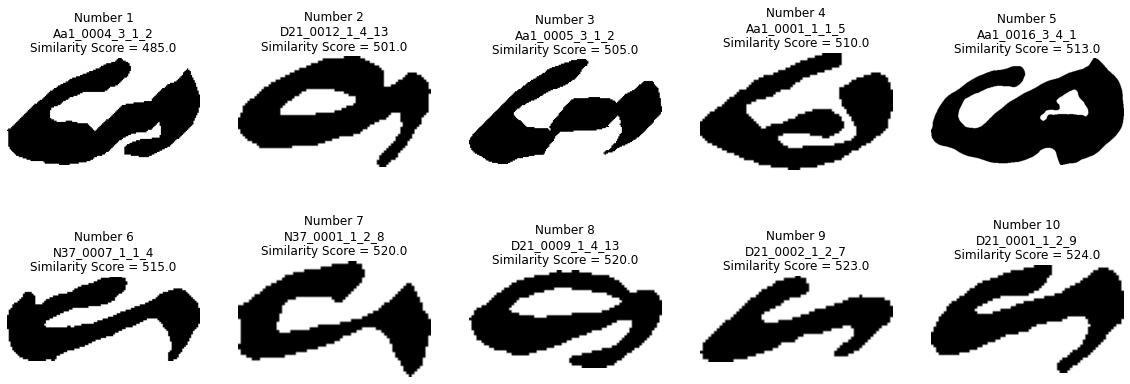

In [13]:
# identify one image
location = '/Users/.../image.png' # image to be analyzed
bounds = 0.15 # specify range to take above and below aspect ratio
size = 20 # size of the images (20 = best by test)
C = size # FFT constant (size = best by test)
D = 3 # FFT constant (3 = best by test)
g = 1100 #(1100 = best by test)
fft_thresh = 9500000 # threshold for cutting off by FFT values
context = 2 # IDM constant (2 = best by test)
warp = 4 # IDM constant (4 = best by test)

m,n = IDM(location, bounds, size, C, D, g, fft_thresh, context, warp)

# Identify one image with FFT only (faster, but less accurate)

There are 3129 images not filtered out by aspect ratio.


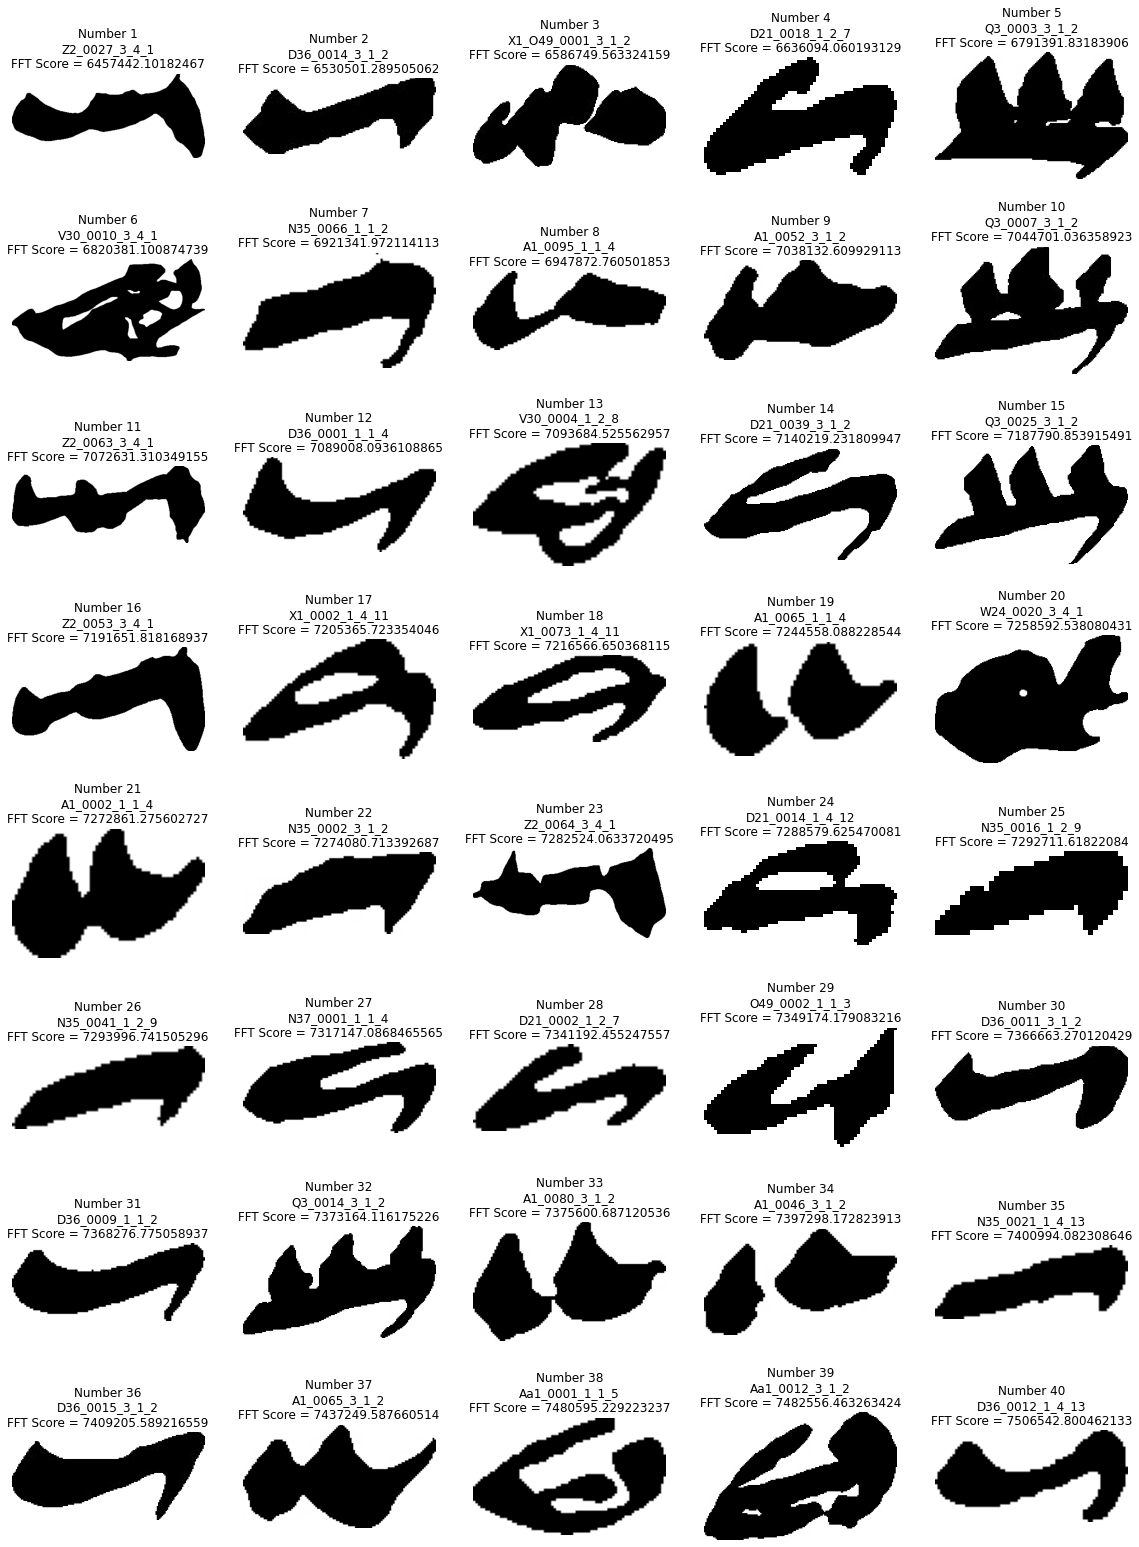

In [8]:
# identify one image with FFT only (faster, but less accurate)
location = '/Users/julius/Desktop/aaaaaa.png' # image to be analyzed
bounds = 0.15 # specify range to take above and below aspect ratio
size = 20 # size of the images (20 = best by test)
C = size # FFT constant (size = best by test)
D = 3 # FFT constant (3 = best by test)
g = 1100 #(1100 = best by test)
fft_thresh = 9500000 # threshold for cutting off by FFT values
context = 2 # IDM constant (2 = best by test)
warp = 4 # IDM constant (4 = best by test)

FFT_only(location, bounds, size, C, D, g, fft_thresh, context, warp)